# Worst Fit

#### Set path

In [1]:
# Define paths
PROJECT_PATH = r'G:\Shared drives\v1_v4_1024'

#### Imports

In [2]:
# general
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import odml
from fooof import FOOOF, FOOOFGroup
from fooof.plts import plot_spectrum

# custom
import sys
sys.path.append("../")
from scripts.plots import plot_psd_diff

#### Settings

In [3]:
# Session of interest (will ultimately apply to all sessions)
SESSIONS = ["A_SNR_041018", "A_SNR_140819", "L_SNR_250717"]
SESSION = "A_SNR_140819"

In [21]:
# Dataset details
FS = 500 # sampling frequency
N_ARRAYS = 16 # number of arrays

# SpecParam settings
FREQ_RANGE = [1, 100] 
N_JOBS = -1 # number of jobs for parallel processing
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [4, np.inf], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0.1, 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2.0, # (default: 2.0)
    'aperiodic_mode'    :   'knee',
    'verbose'           :   False}

#### Functions

## Main

#### Create output directory

In [ ]:
# dir_out = f"{PROJECT_PATH}/figures/"
# if not os.path.exists(dir_out):
#     os.makedirs(dir_out)

#### Load data

In [ ]:
# # define odml file path (contains metadata including electrode positions)
# odml_path = fr"{PROJECT_PATH}\data\metadata\{SESSION}\metadata_{SESSION}.odml"
# metadata = odml.load(odml_path)

#### Find worst fit

In [5]:
# Initialize a FOOOFGroup object
fg_pre = FOOOFGroup()
fg_post = FOOOFGroup()
fg_pre.load(r"G:\Shared drives\v1_v4_1024\data\lfp\lfp_params\A_SNR_041018_lfp_pre.csv")
fg_post.load(r"G:\Shared drives\v1_v4_1024\data\lfp\lfp_params\A_SNR_041018_lfp_post.csv")

In [6]:
r_pre = fg_pre.get_params('r_squared')
r_post = fg_post.get_params('r_squared')

print("r_squaed pre values below 0.90:")
for i in r_pre :
    if i < 0.90 :
        print(i)

print("\n r_squaed post values below 0.90:")
for i in r_post :
    if i < 0.90 :
        print(i)

r_squaed pre values below 0.90:
0.8671814265659766
0.8417929279089499
0.7590637137183911
0.860281732508009
0.6902503259019094
0.7982953984260774
0.821354676883058
0.8216318560546101

 r_squaed post values below 0.90:


In [7]:
# get indices of low r_squared values
low_r_squared = np.argwhere(r_pre < 0.9).flatten()
low_r_squared

array([363, 366, 374, 376, 382, 616, 625, 626], dtype=int64)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     7.2665, 554.8473, 2.3825                                     
                                                                                                  
                                       0 peaks were found:                                        
          

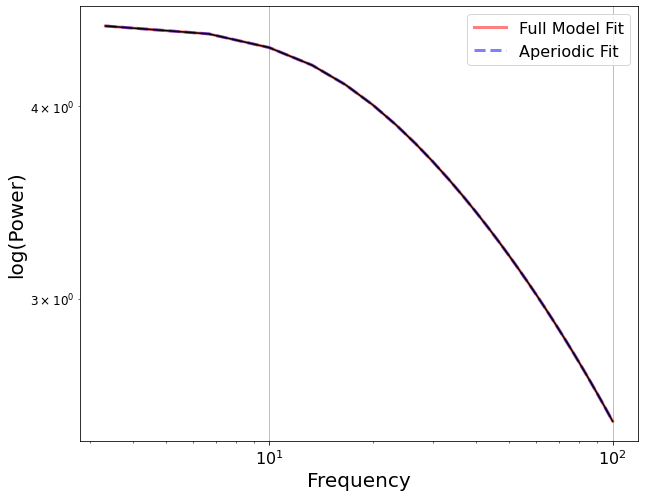

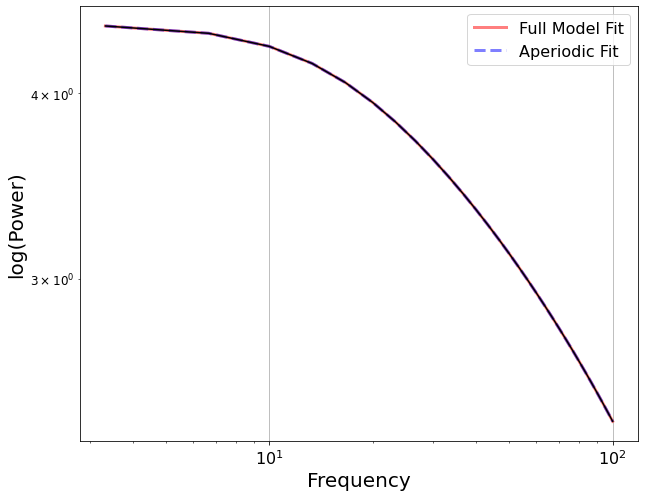

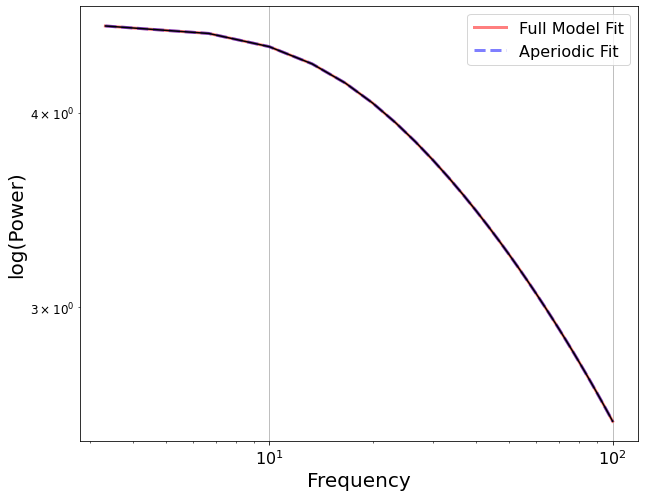

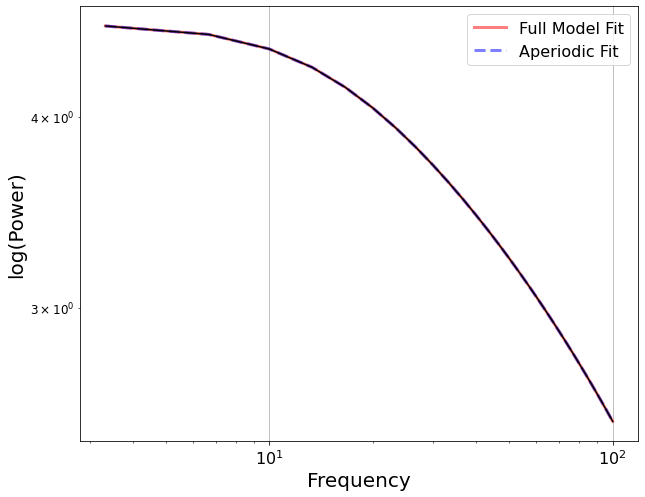

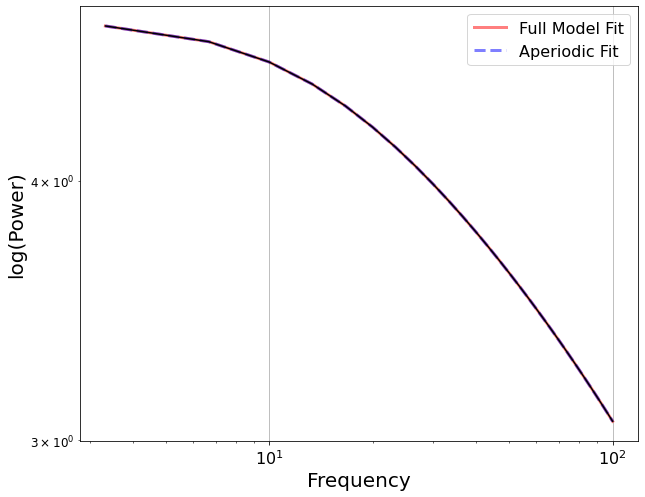

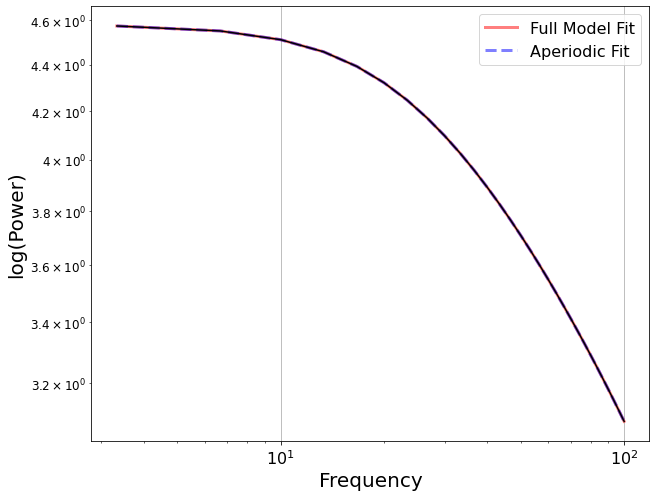

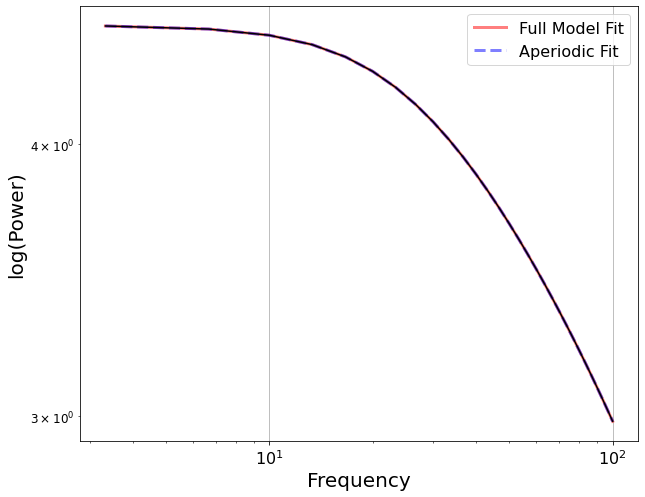

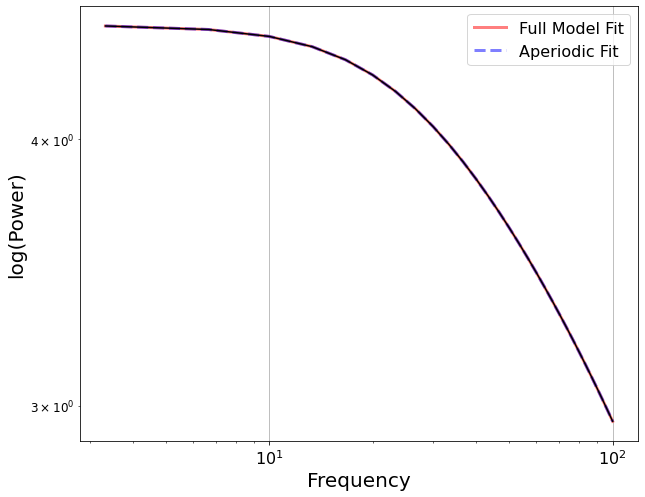

In [8]:
# Extract this model fit from the group
for val in low_r_squared:
    fm = fg_pre.get_fooof(val, regenerate=True)

    # Check results and visualize the extracted model
    fm.print_results()

    # plot
    fm.plot()
    spectrum = fm.fooofed_spectrum_
    freqs = fm.freqs
    ax = plt.gca()
    ax.plot(freqs, spectrum, color='k')
    ax.set(xscale='log', yscale='log')

#### Calculating max error psd

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     7.3503, 620.5792, 2.4053                                     
                                                                                                  
                                       0 peaks were found:                                        
          

[None, None]

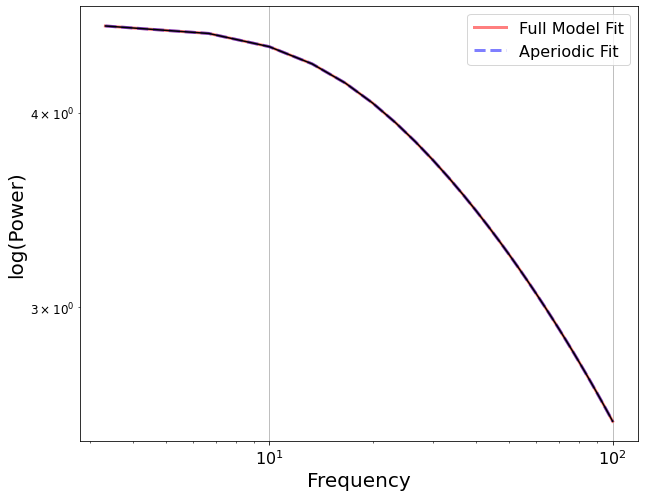

In [20]:
# Find the index of the worst model fit from the group
worst_fit_ind = np.argmax(fg_pre.get_params('error'))

# Extract this model fit from the group
fm = fg_pre.get_fooof(worst_fit_ind, regenerate=True)

# Check results and visualize the extracted model

# print
fm.print_results()
print(fm.get_params('r_squared'))

# plot
fm.plot()
ax = plt.gca()
ax.plot(fm.freqs, fm.fooofed_spectrum_, color='k')
ax.set(xscale='log', yscale='log')


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.33 <= 4.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

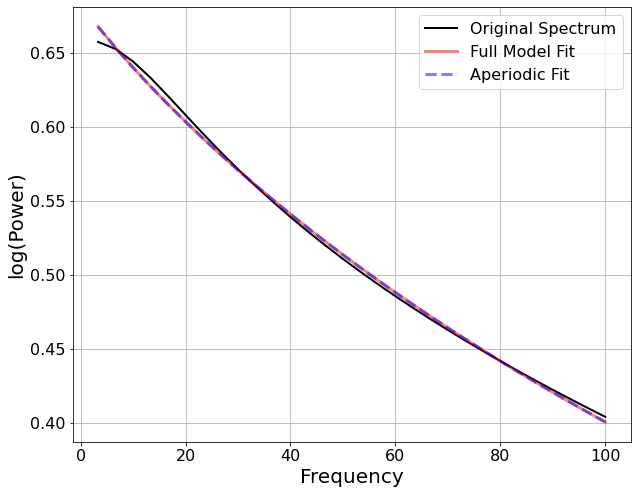

In [13]:
# re-fit and compare

# unpack 
freq = fm.freqs
spectrum = fm.fooofed_spectrum_
spec_param_settings = fm.get_settings()
freq_range = fm.freq_range

# fit
fm_refit = FOOOF(*spec_param_settings)
fm_refit.report(freq, spectrum, freq_range)
# fm_refit.fit(freq, spectrum, freq_range)
# fm_refit.print_results()


In [21]:
# check if data was corrupted during saving/loading (accidentally saved as csv)
 
# save
fg_pre.save('test.csv', save_results=True)
fg_pre.save('test', save_results=True)

# load
fg_from_csv = FOOOFGroup()
fg_from_csv.load('test.csv')
fg_from_json = FOOOFGroup()
fg_from_json.load('test.json')

# compare
r2_from_csv = fg_from_csv.get_params('r_squared')
r2_from_json = fg_from_json.get_params('r_squared')
print((r2_from_csv==r2_from_json).all())

True


#### load PSD results and refit

In [51]:
# aggregate PSDs across arrays, compute difference and plot

# initialize
psd_pre_list = []
psd_post_list = []

# loop over sessions
for i_array in range(N_ARRAYS):
    # load psd
    nps_idx = (i_array+2) // 2
    fname_in = f"{PROJECT_PATH}/data/lfp/lfp_psd/A_SNR_041018/NSP{nps_idx}_array{i_array+1}_LFP_XXX.npz"
    psd_pre_list.append(np.load(fname_in.replace('XXX', 'pre'))['spectra'])
    psd_post_list.append(np.load(fname_in.replace('XXX', 'post'))['spectra'])

# get freq vector
freq = np.load(fname_in.replace('XXX', 'pre'))['freq']

# join psds across arrays into single array
psd_pre = np.concatenate(psd_pre_list, axis=1)
psd_post = np.concatenate(psd_post_list, axis=1)

In [81]:
#fg.fit(freq,spectra)
# Average over trials (average psd_pre frequency)
psd_pre_avg = np.mean(psd_pre, axis = 0)

# index channels for worst one
worst_fit_spec = psd_pre_avg[worst_fit_ind]
worst_fit_spec

# fit fooof model
fg_worst = FOOOF(**SPEC_PARAM_SETTINGS)
fg_worst.fit(freq, worst_fit_spec, freq_range=FREQ_RANGE)

In [72]:
print(f"worst_fit_spec: {worst_fit_spec.shape} \nfreq: {freq.shape}")

worst_fit_spec: (76,) 
freq: (76,)


In [82]:
# compare results to ones above in gorup object
fm.print_results()
fg_worst.print_results()


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     7.2665, 554.8473, 2.3825                                     
                                                                                                  
                                       0 peaks were found:                                        
          

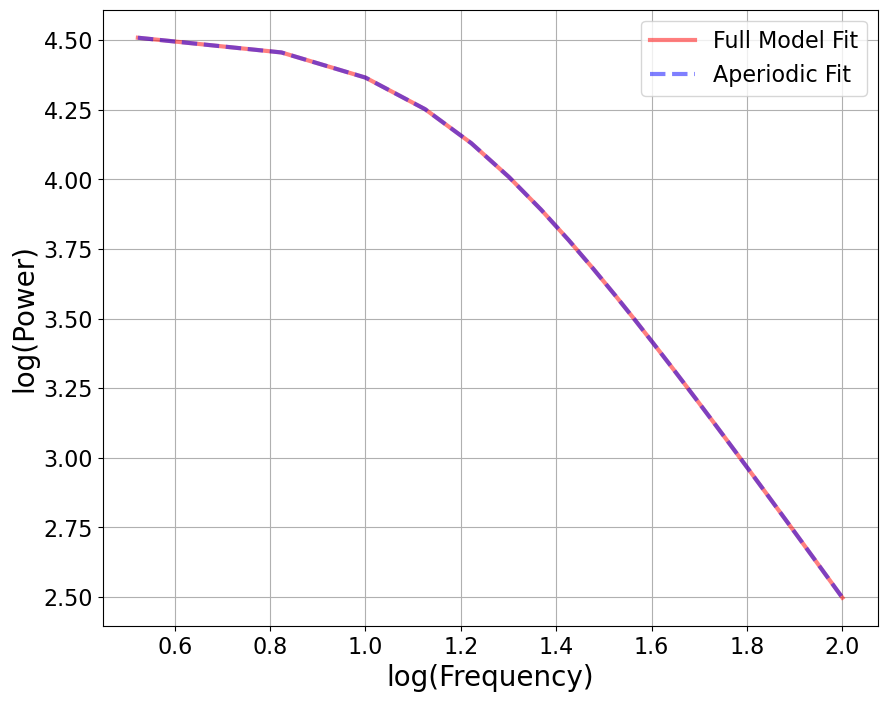

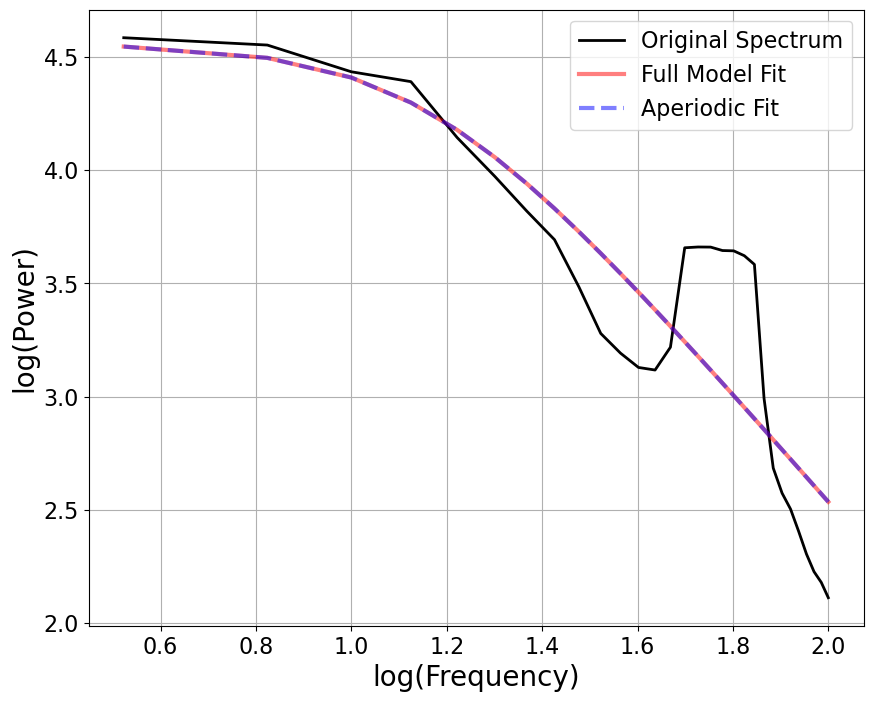

In [84]:
fm.plot(plt_log=True)
fg_worst.plot(plt_log=True)

## Explore fits which have peaks at the width limits

In [5]:
df_spec = pd.read_csv(f"{PROJECT_PATH}/data/results/lfp_spectral_params.csv", index_col=0)
df_spec

,session,channel,chan_idx,array,epoch,offset,knee,exponent,cf_0,pw_0,...,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
0,A_SNR_140819,0,0,1,pre,8.250311,5413.760937,3.660094,20.761566,0.293874,...,0.197448,9.742920,69.580402,0.226458,4.000000,NaN,NaN,NaN,0.031894,0.998489
1,A_SNR_140819,1,1,1,pre,8.123542,5823.334791,3.641594,21.187425,0.275064,...,0.218554,9.161468,69.608105,0.252213,4.000000,NaN,NaN,NaN,0.024117,0.998853
2,A_SNR_140819,2,2,1,pre,7.435895,1192.281172,3.096264,13.167393,0.255324,...,0.230272,11.088440,83.034727,0.265393,20.000000,NaN,NaN,NaN,0.051569,0.994847
3,A_SNR_140819,3,3,1,pre,8.042354,5815.931666,3.603246,21.469165,0.259553,...,0.174634,9.513133,69.419959,0.268177,4.000000,NaN,NaN,NaN,0.021202,0.998999
4,A_SNR_140819,4,4,1,pre,7.885415,4011.093210,3.485834,21.199995,0.275271,...,0.179327,10.023394,69.388871,0.270873,4.000000,NaN,NaN,NaN,0.021975,0.998878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,A_SNR_041018,59,1019,16,post,8.218674,920.375636,2.957407,15.313949,0.346989,...,0.361749,6.217917,53.053373,0.417390,7.605257,66.240554,0.618275,12.202779,0.036642,0.997392
6140,A_SNR_041018,60,1020,16,post,7.957116,524.482942,2.840909,15.249014,0.339185,...,0.337440,5.783263,52.554341,0.341313,6.525079,66.035262,0.526361,13.776319,0.037998,0.997116
6141,A_SNR_041018,61,1021,16,post,7.514403,161.380709,2.477766,15.290988,0.332045,...,0.274705,4.258126,52.224874,0.303241,6.001945,66.135492,0.458828,15.696865,0.038280,0.996419
6142,A_SNR_041018,62,1022,16,post,7.782704,394.067650,2.638067,18.368436,0.290650,...,0.335045,6.784725,66.136008,0.497800,13.875347,NaN,NaN,NaN,0.039157,0.996628


,session,channel,chan_idx,array,epoch,offset,knee,exponent,cf_0,pw_0,...,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
6066,A_SNR_041018,50,946,15,post,9.370681,70241.655333,3.730644,24.897212,0.279321,...,0.248443,20.0,NaN,NaN,NaN,NaN,NaN,NaN,0.047759,0.995383
6067,A_SNR_041018,51,947,15,post,8.483598,8015.640098,3.166260,24.045312,0.368671,...,0.243767,20.0,NaN,NaN,NaN,NaN,NaN,NaN,0.044601,0.995439
6068,A_SNR_041018,52,948,15,post,8.287781,4593.041732,3.068342,23.891420,0.394256,...,0.150894,20.0,NaN,NaN,NaN,NaN,NaN,NaN,0.032287,0.997839
6072,A_SNR_041018,56,952,15,post,8.939241,39585.874853,3.561667,26.510392,0.285914,...,0.145076,20.0,NaN,NaN,NaN,NaN,NaN,NaN,0.031610,0.997723
6075,A_SNR_041018,59,955,15,post,9.220710,53064.512492,3.639062,24.768144,0.259407,...,0.237492,20.0,NaN,NaN,NaN,NaN,NaN,NaN,0.043772,0.995507


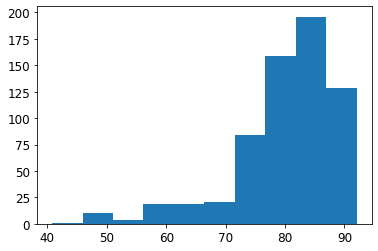

In [6]:
df = df_spec[df_spec['bw_1']==20]
plt.hist(df['cf_1'])
df.tail()

In [18]:
# load example data
fname = r"G:\Shared drives\v1_v4_1024\data\lfp\lfp_psd\A_SNR_041018\NSP8_array15_LFP_pre.npz"
data_in = np.load(fname)
print(data_in.files)
spectra = data_in['spectra']
freq = data_in['freq']
print(spectra.shape)
print(freq.shape)

# compute mean across trials
spectra_mean = np.mean(spectra, axis=0)
print(spectra_mean.shape)

['spectra', 'freq']
(102, 64, 76)
(76,)
(64, 76)


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 97 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    8.1591, 3513.8394, 3.0844                                     
                                                                                                  
                                       1 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 97 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    9.1745, 75613.5482, 3.8038                                    
                                                                                                  
                                       2 peaks were found:                                        
          

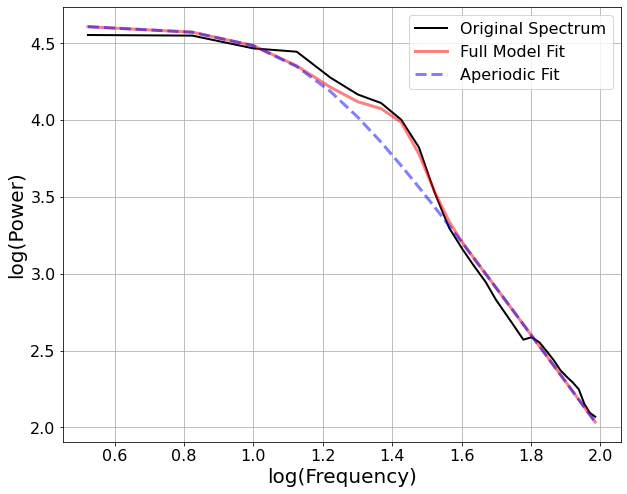

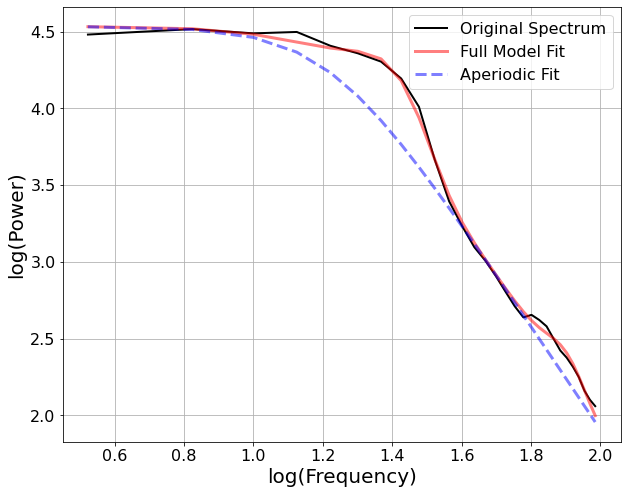

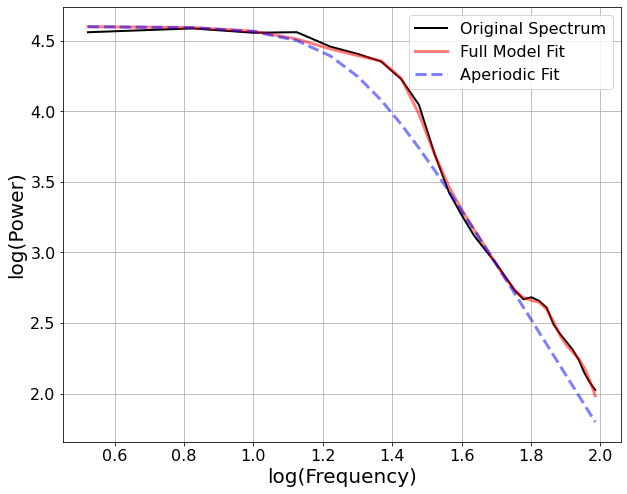

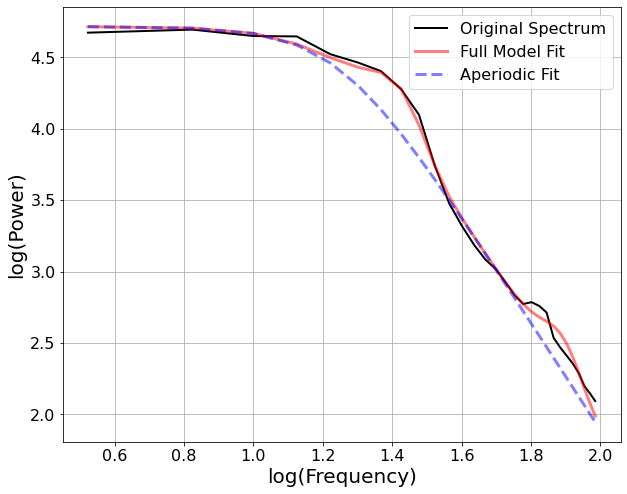

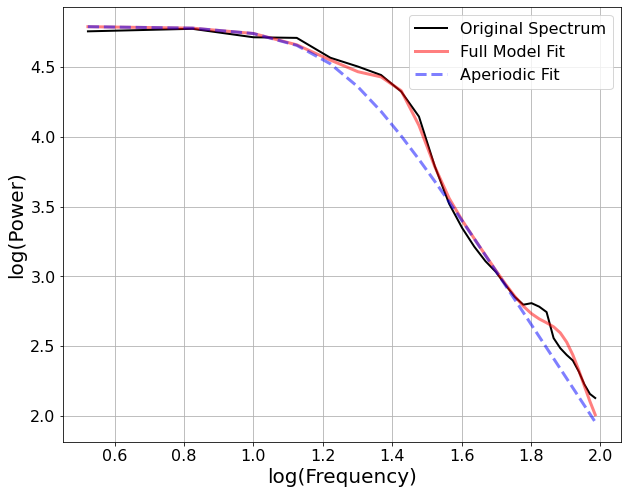

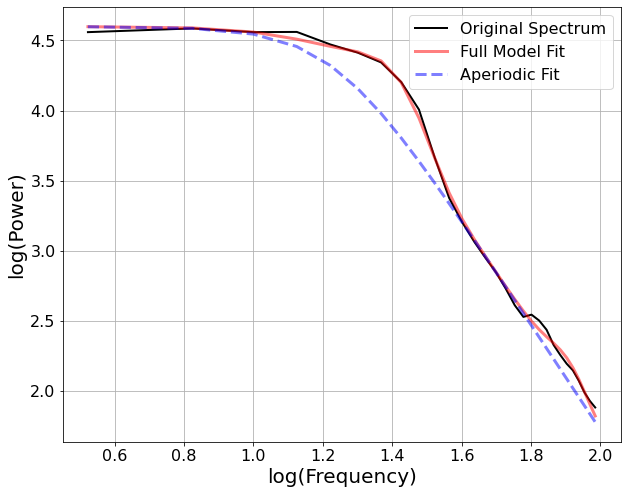

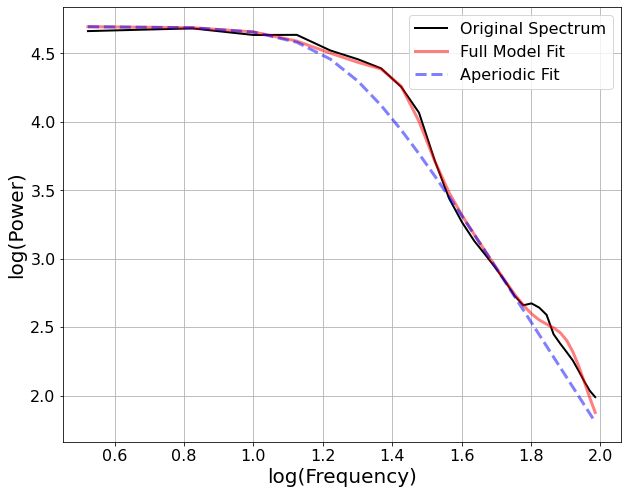

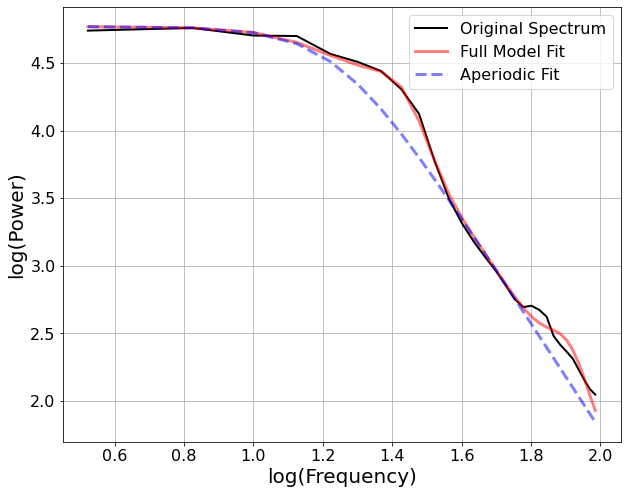

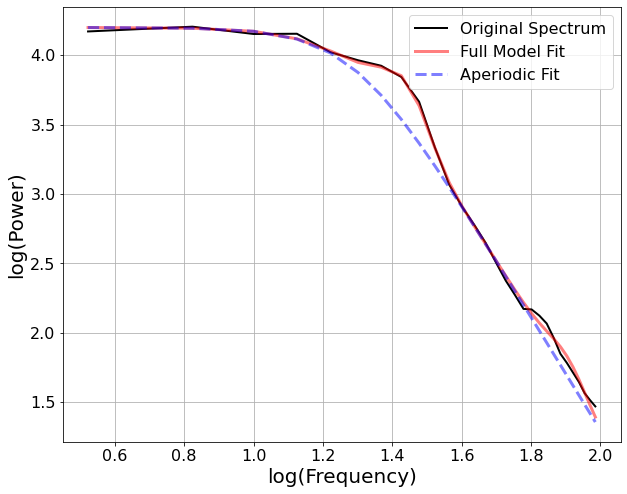

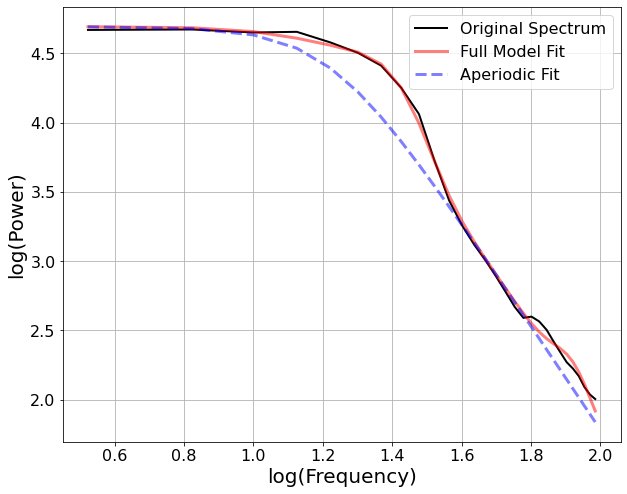

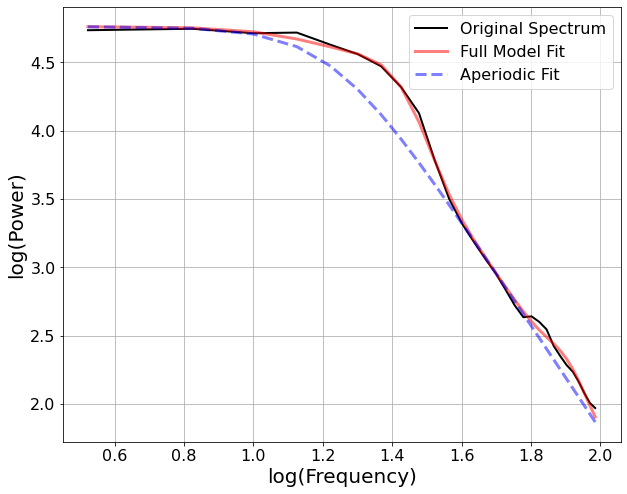

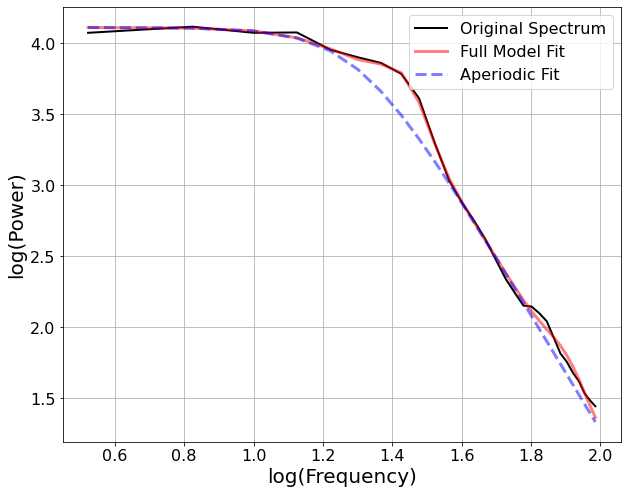

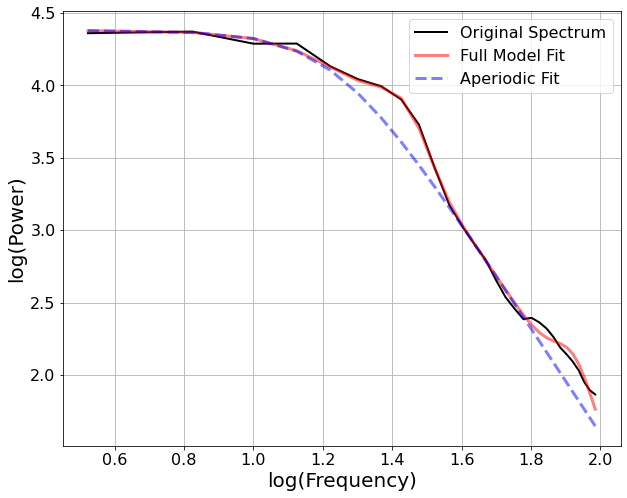

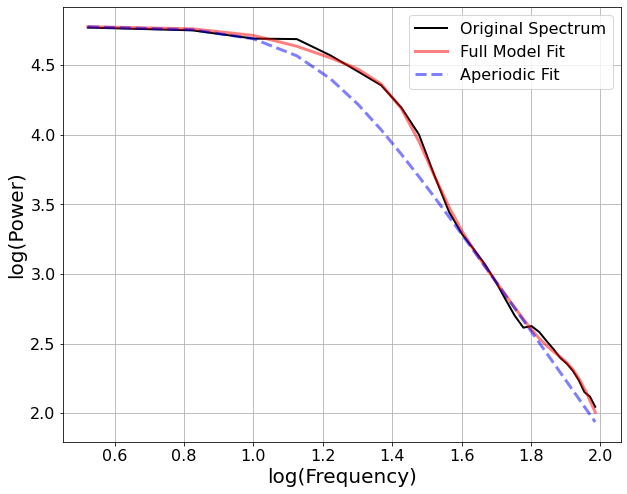

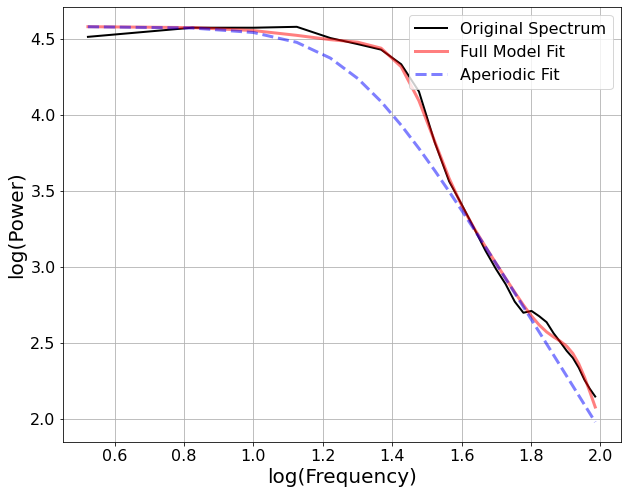

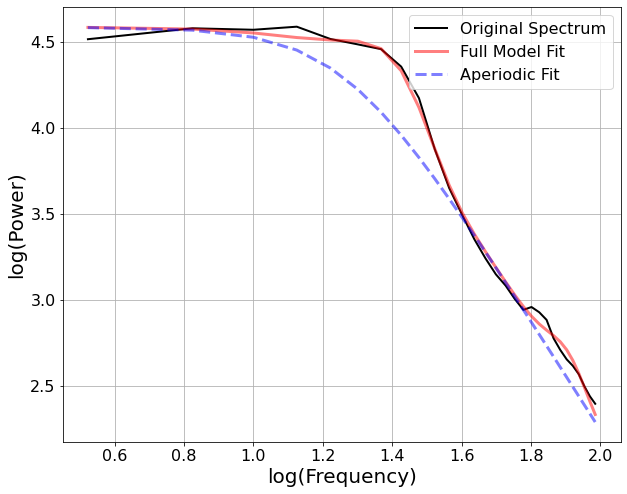

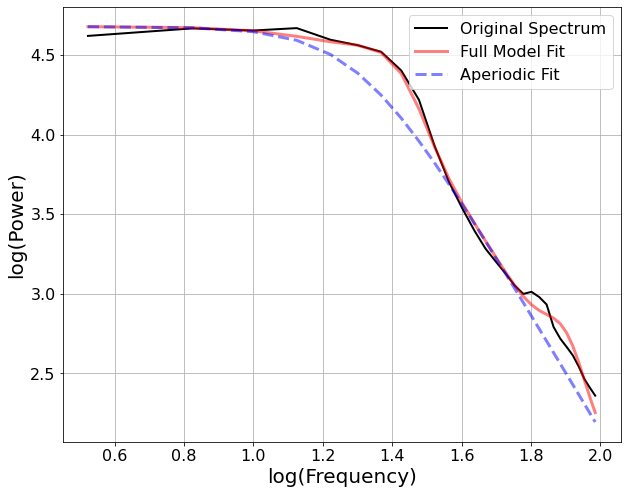

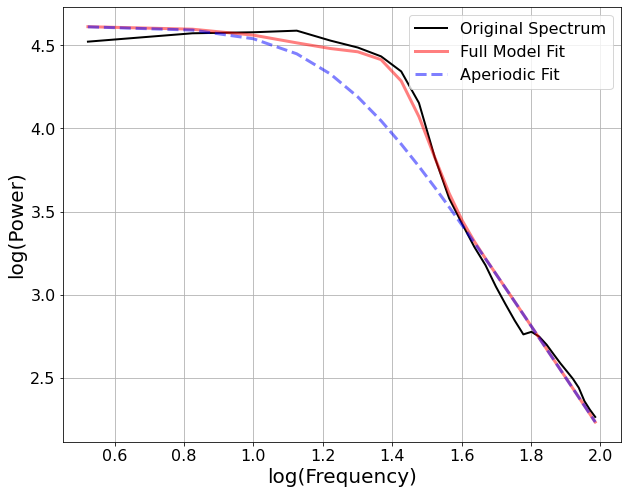

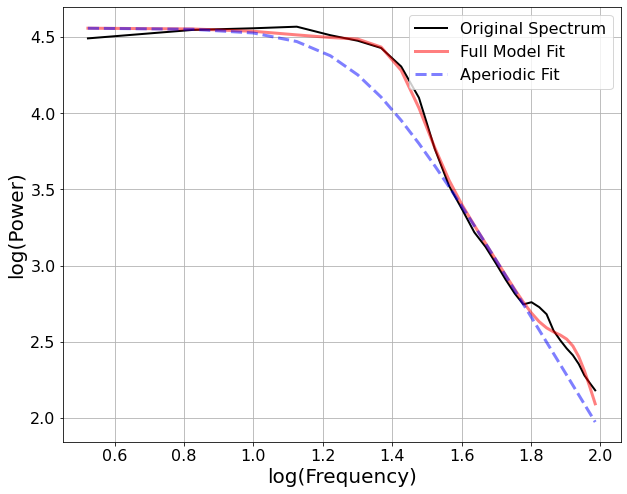

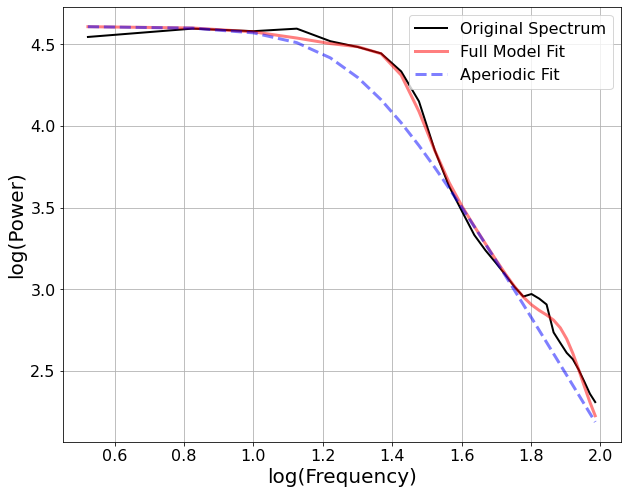

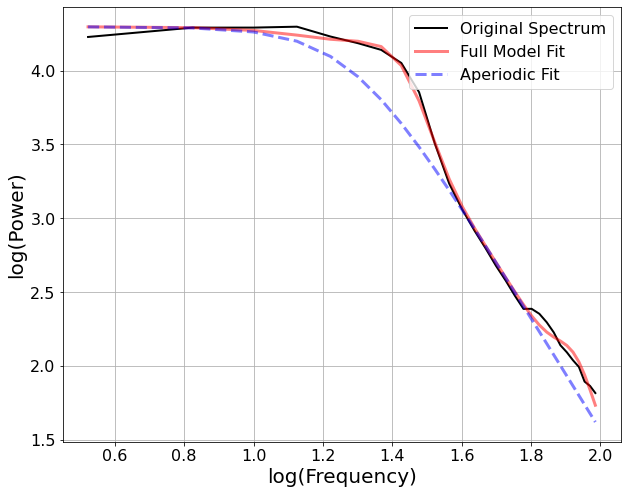

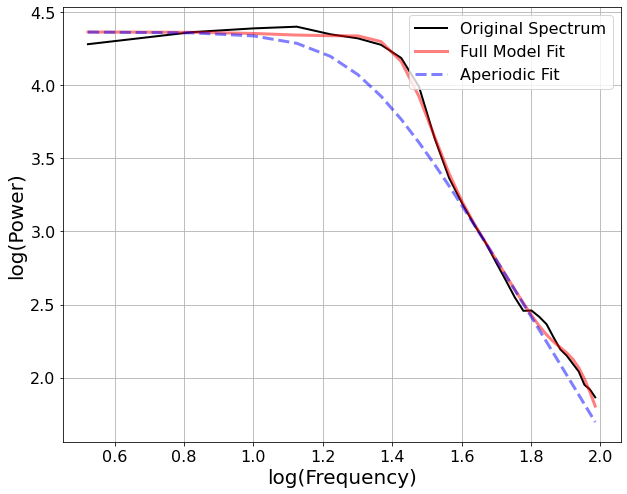

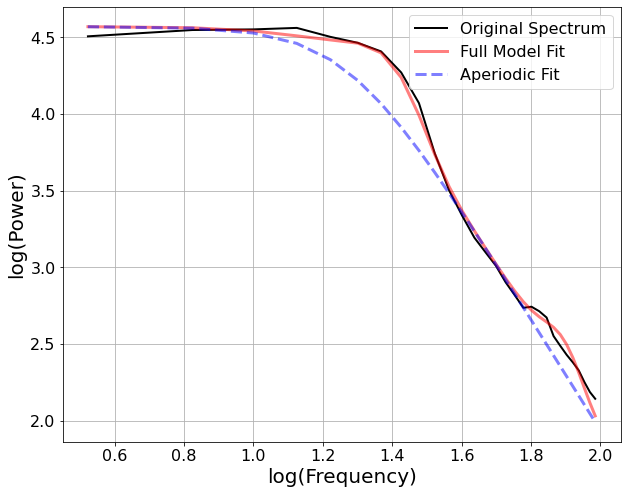

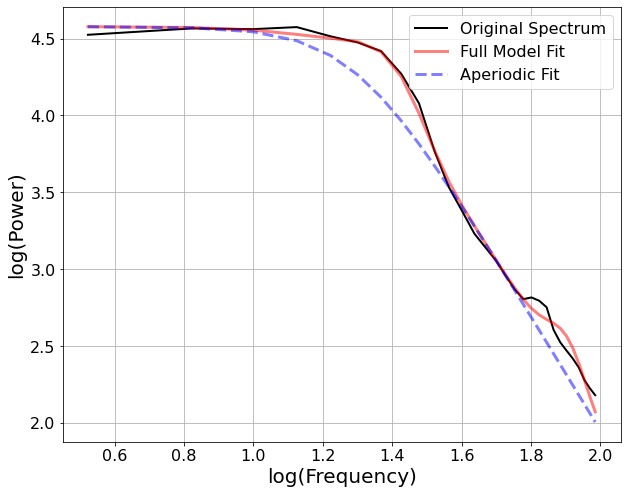

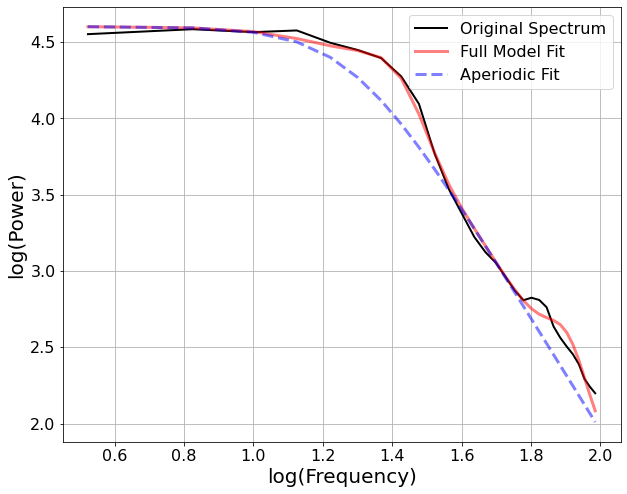

In [33]:
# plot spectral fit (0-100 frequency range as used in pipeline)

# set frequency range
freq_idx = (freq>0) & (freq<100)

# # plot each channel separately
# for i_chan in range(spectra_mean.shape[0]):
#     plot_spectrum(freq[freq_idx], spectra_mean[i_chan, freq_idx], log_freqs=True, log_powers=True)

# plot fit for select channels
chan_idx = df.loc[(df['session']=='A_SNR_041018') & (df['array']==15) & (df['epoch']=='pre'), 'channel'].values.astype(int)
for i_chan in chan_idx:
    model = FOOOF(**SPEC_PARAM_SETTINGS)
    model.report(freq[freq_idx], spectra_mean[i_chan, freq_idx], plt_log=True)


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 250 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    9.4581, 84003.5464, 3.8823                                    
                                                                                                  
                                       3 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 250 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                   9.7442, 242756.8291, 4.0627                                    
                                                                                                  
                                       4 peaks were found:                                        
          

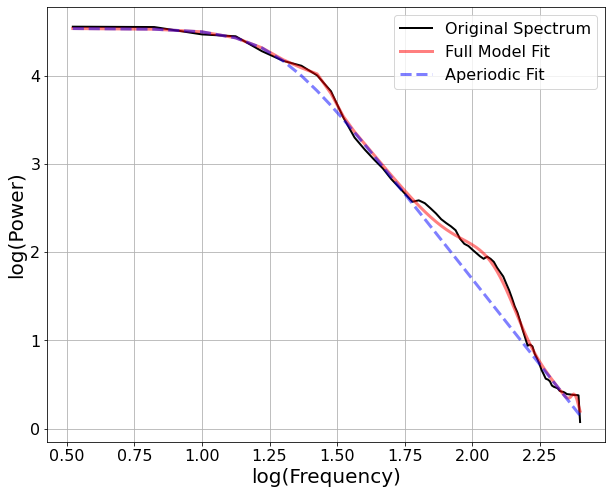

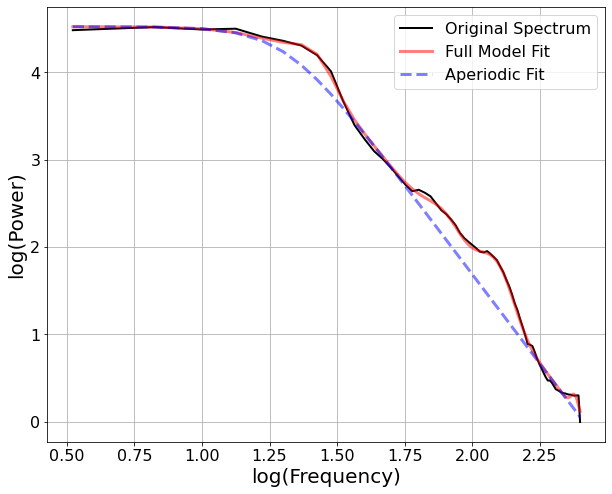

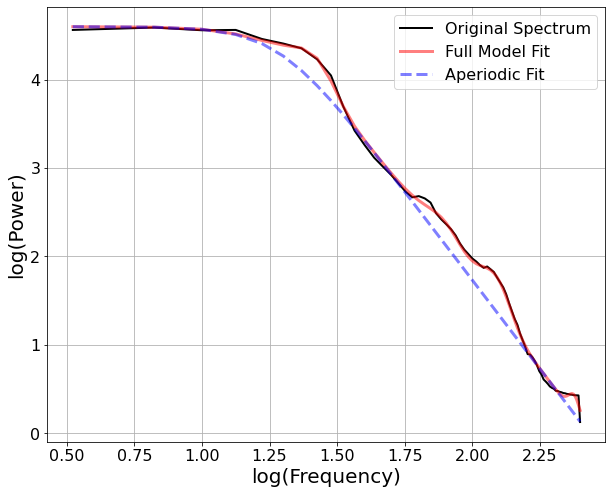

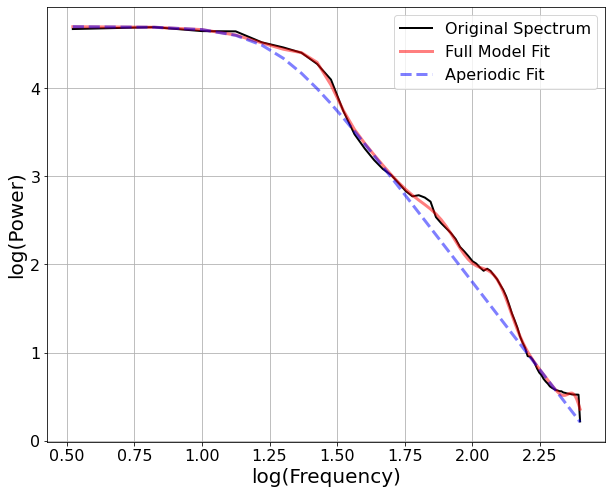

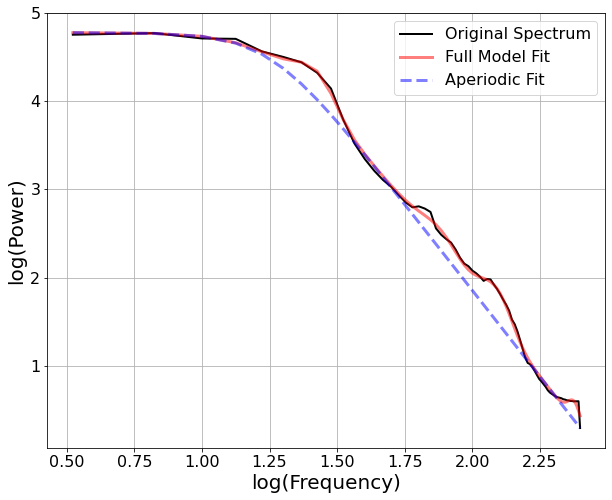

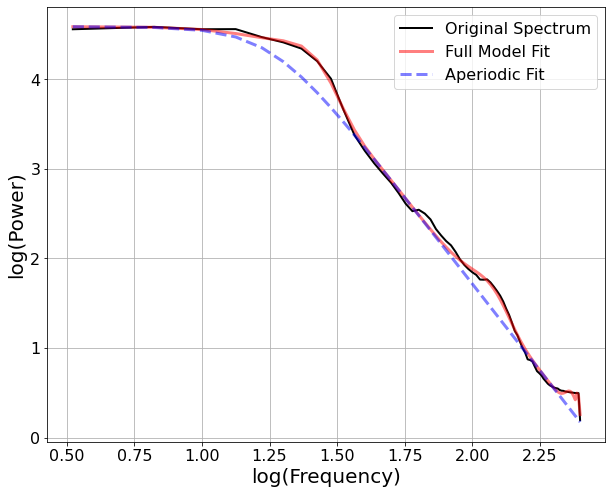

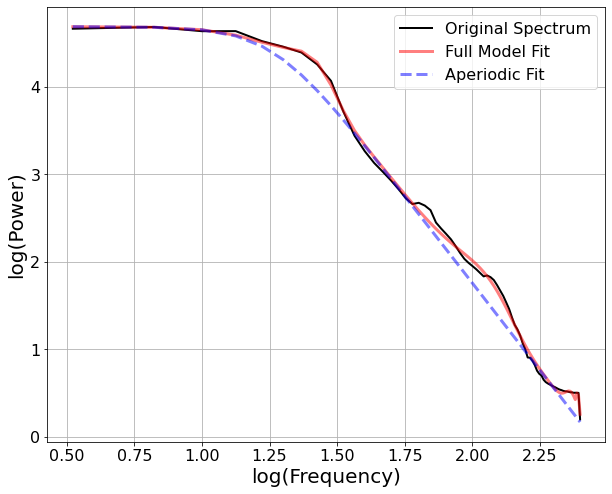

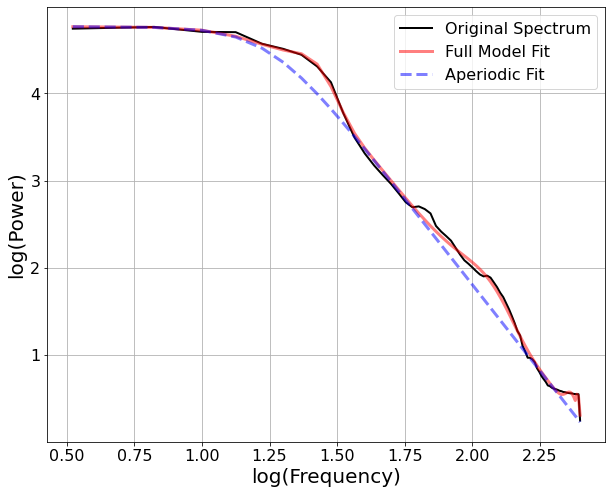

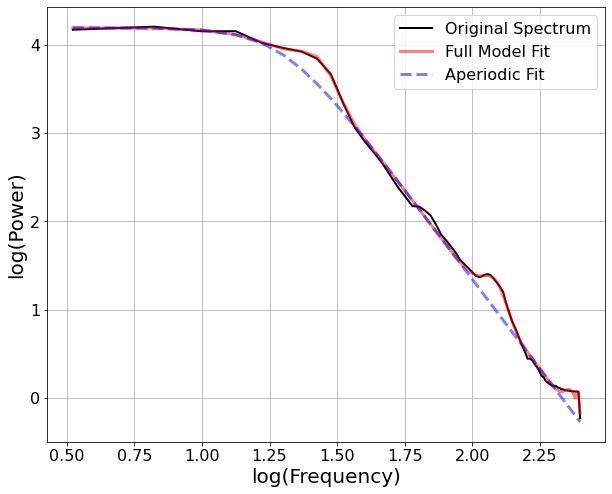

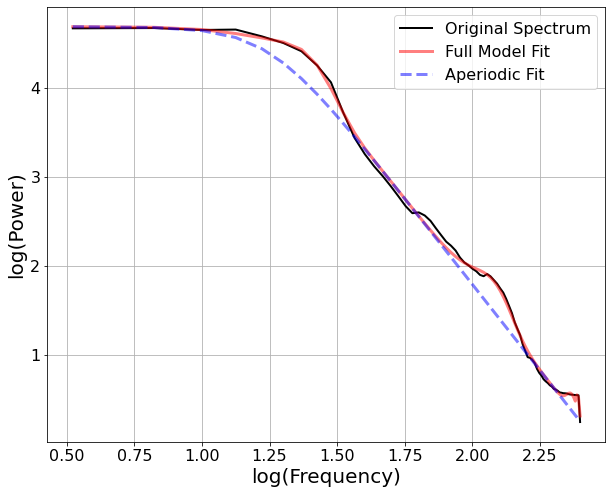

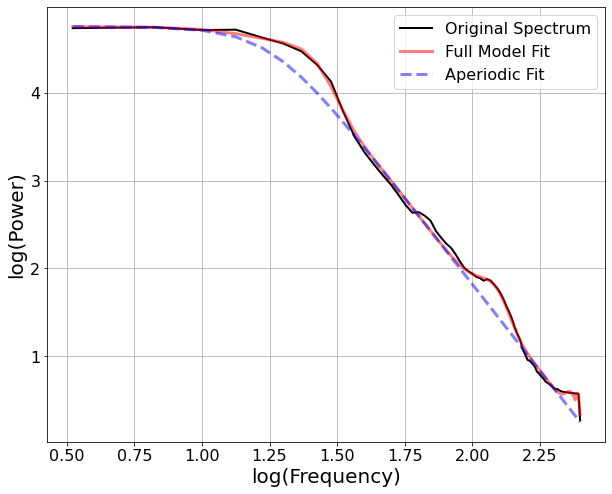

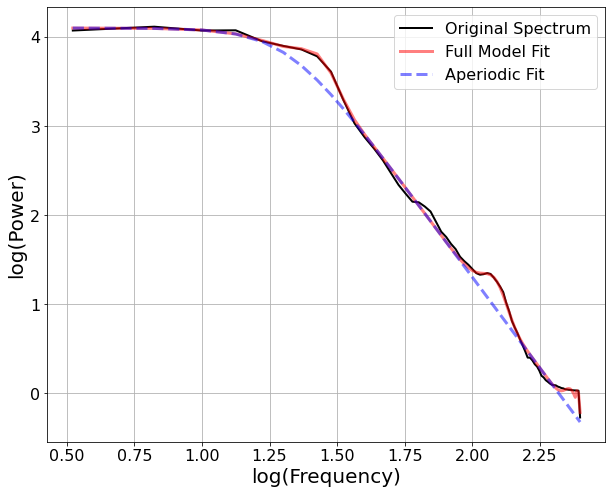

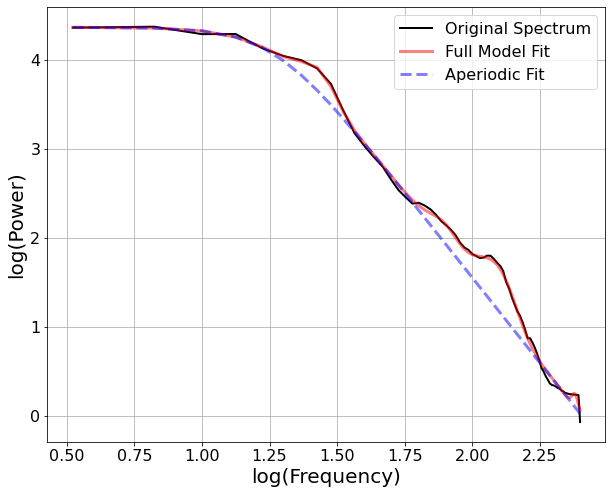

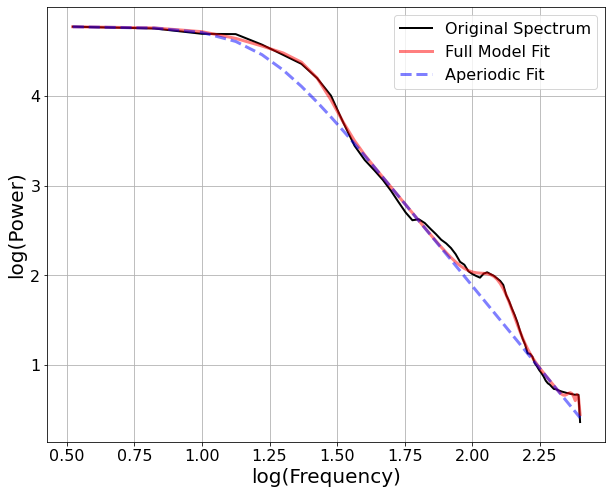

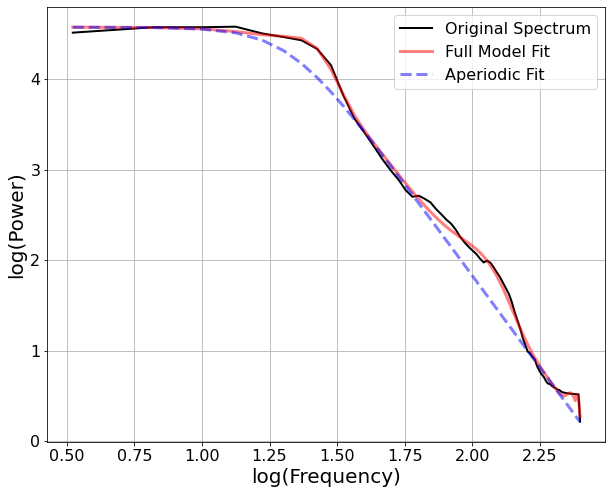

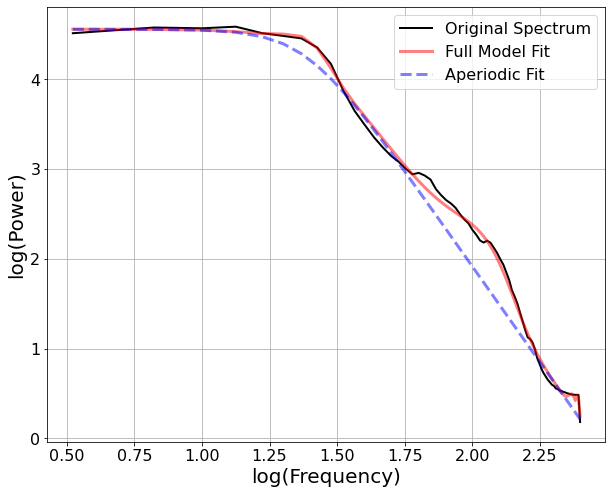

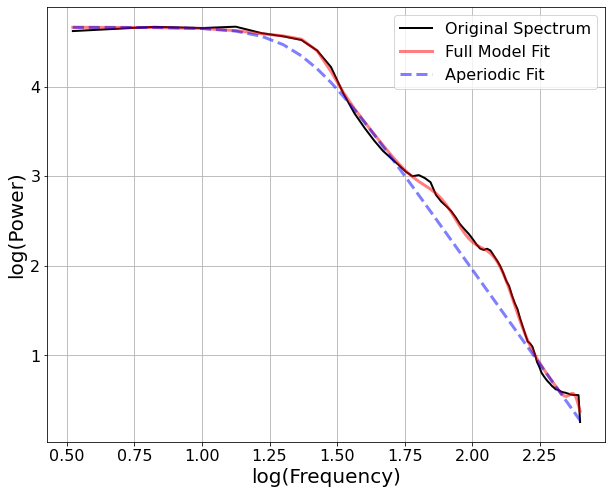

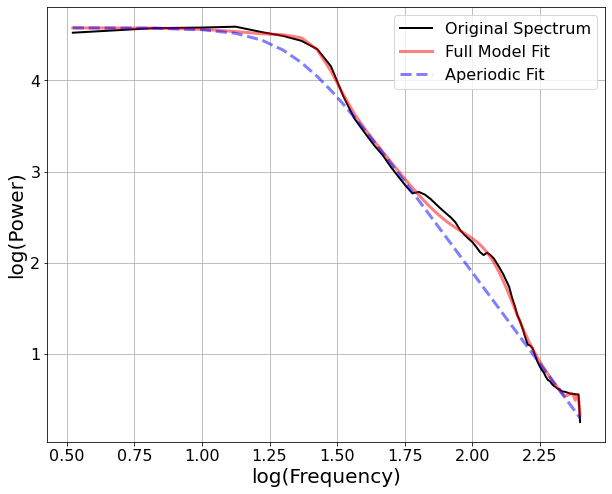

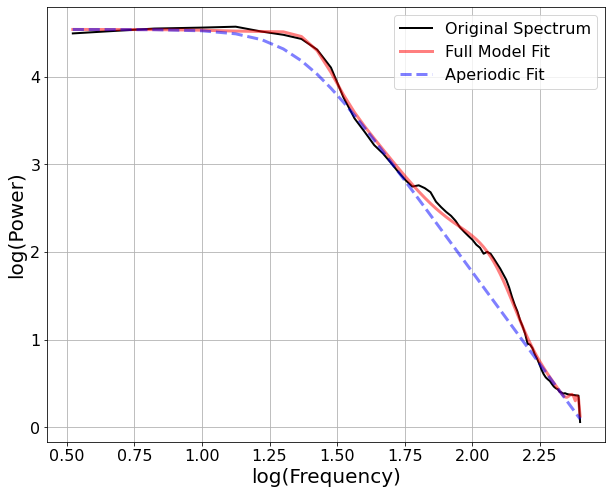

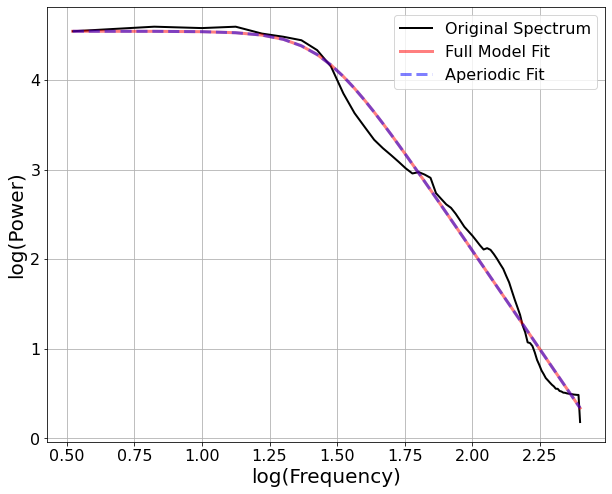

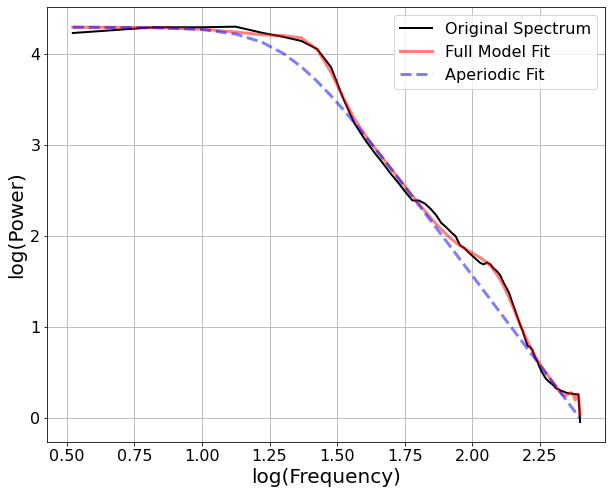

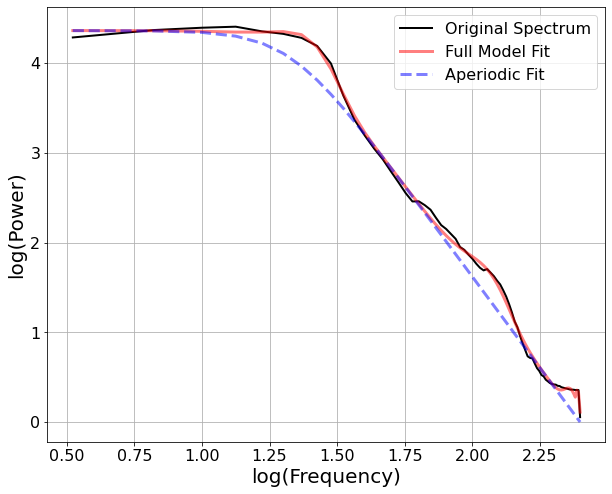

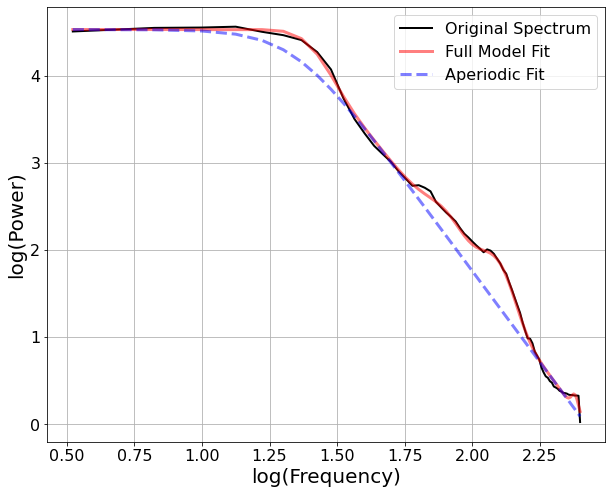

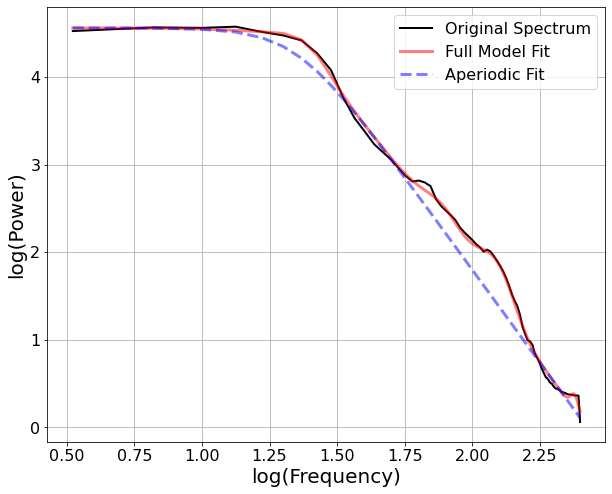

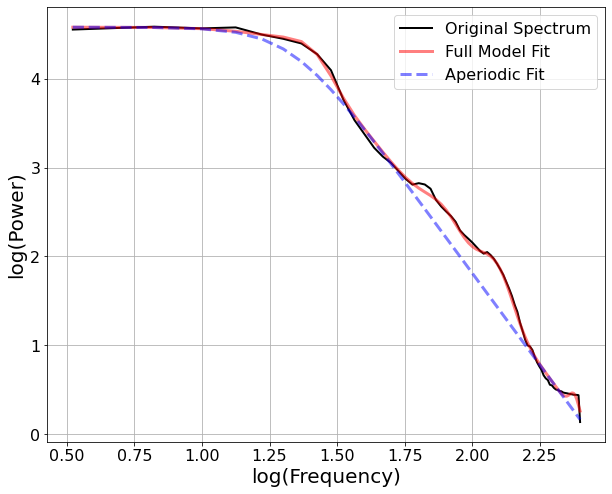

In [22]:
# plot specparam report for example data - no frequency range specified

# # plot each channel separately
# for i_chan in range(spectra_mean.shape[0]):
#     plot_spectrum(freq[freq_idx], spectra_mean[i_chan, freq_idx], log_freqs=True, log_powers=True)

# plot fit for select channels
chan_idx = df.loc[(df['session']=='A_SNR_041018') & (df['array']==15) & (df['epoch']=='pre'), 'channel'].values.astype(int)
for i_chan in chan_idx:
    model = FOOOF(**SPEC_PARAM_SETTINGS)
    model.report(freq, spectra_mean[i_chan], plt_log=True)


It looks like some high-frequency peaks are genuinely broader than 20 Hz, so it may be best to increase the upper width limit... This preview has also revealed that peaks are being fit to what we would typically consider to be the spectral knee, which is non-optimal.

## Investigate single-trial fits

Some of the power spectra are unusually shaped and the spectral fits are non-optimal. Broad peaks in the trial-averaged power spectra may reflect variability in the peak frequency of an oscillation between trials (particularly in the high-frequency range). 

In [25]:
# load example spectral results
fname = r"G:\Shared drives\v1_v4_1024\data\lfp\lfp_psd\sessions\A_SNR_041018_lfp_pre.npz"
data_in = np.load(fname)
spectra = data_in['spectra']
freq = data_in['freq']
print(f"spectra shape: \t{spectra.shape}")
print(f"freq shape: \t{freq.shape}")

spectra shape: 	(102, 1024, 76)
freq shape: 	(76,)


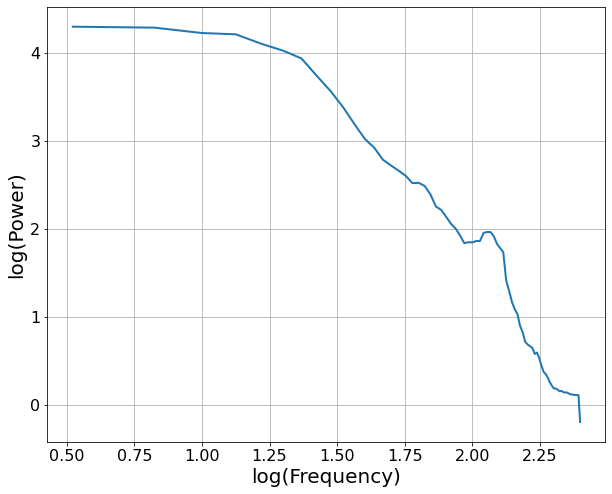

In [29]:
# plot spectra
i_chan = 960
plot_spectrum(freq, np.mean(spectra[:, i_chan], axis=0), log_freqs=True, log_powers=True)

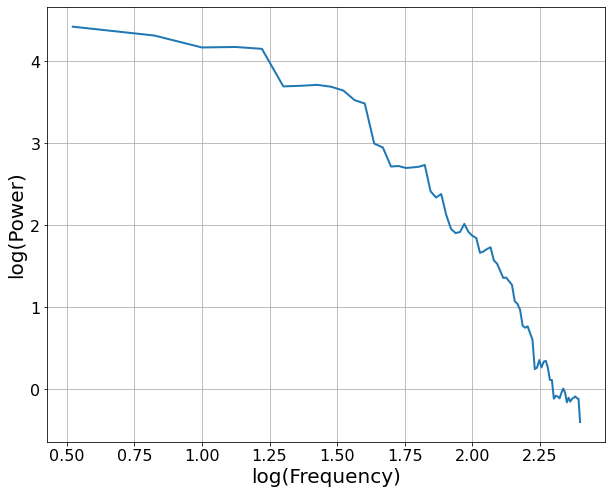

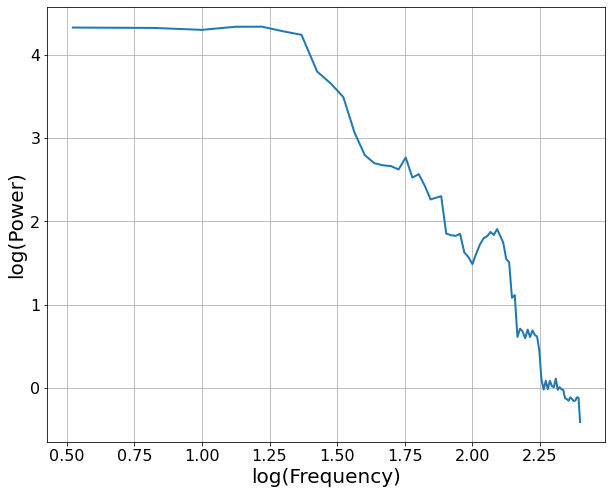

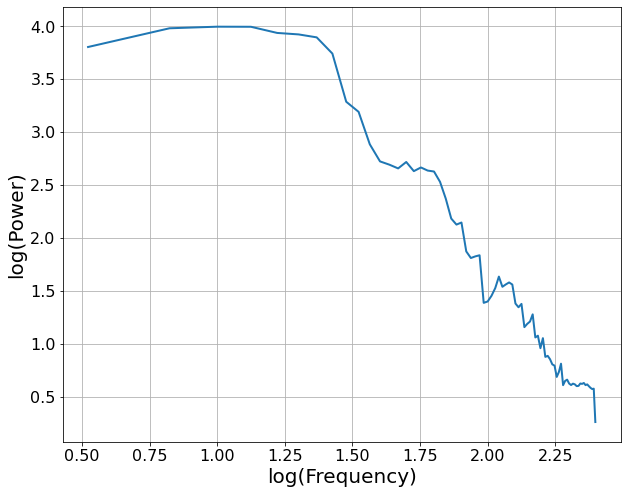

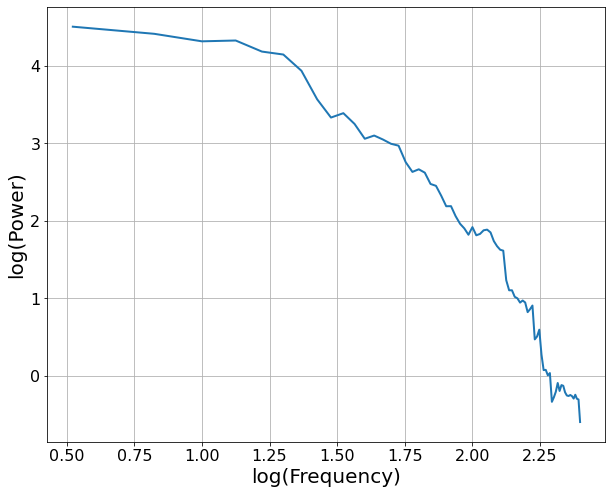

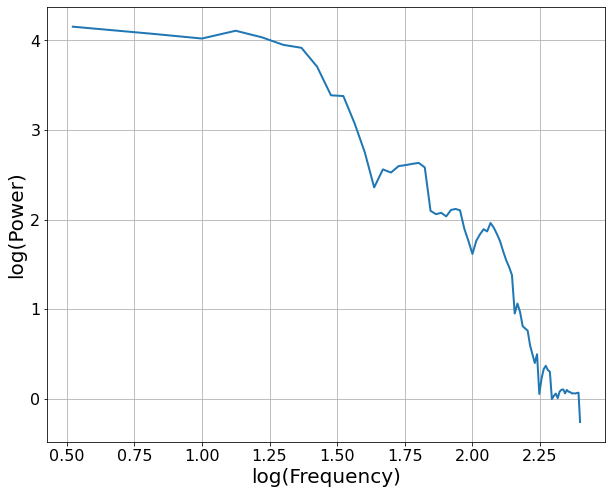

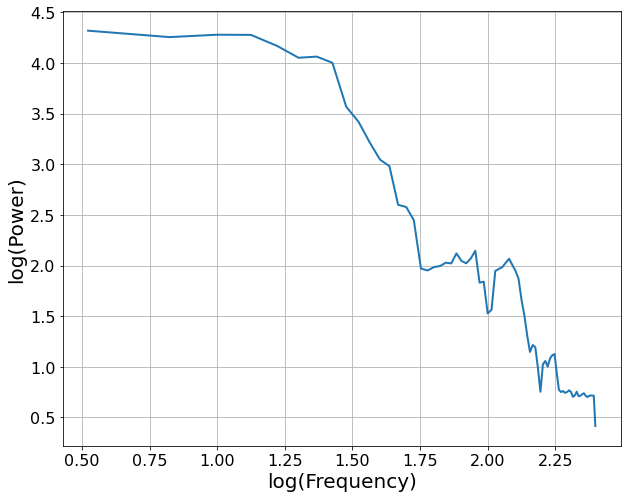

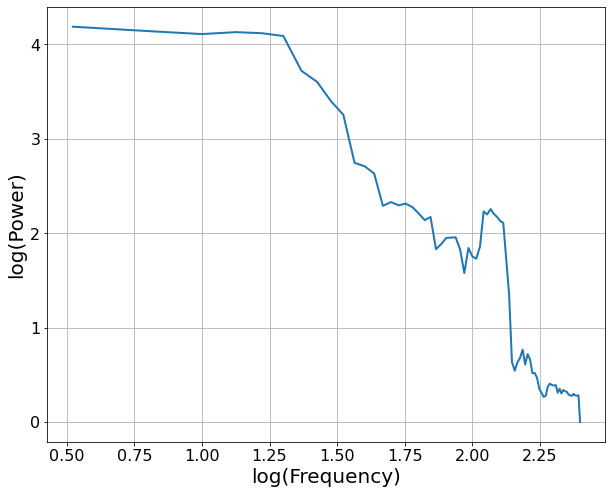

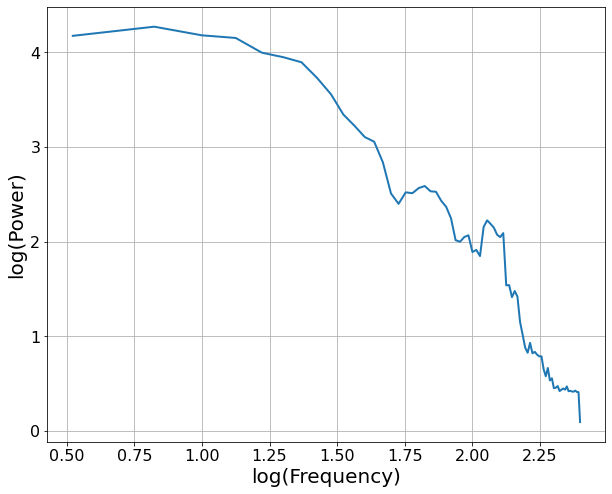

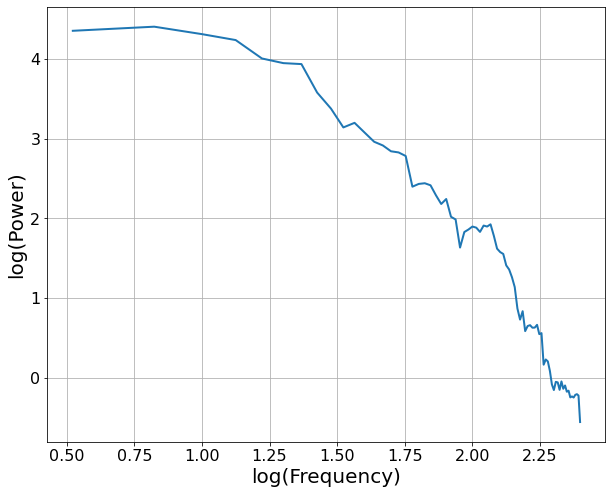

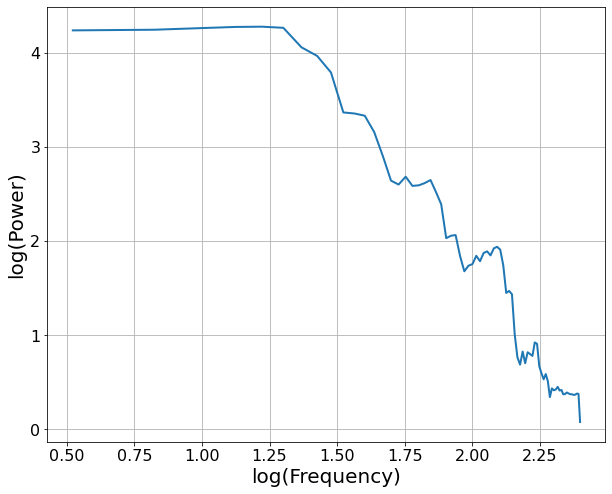

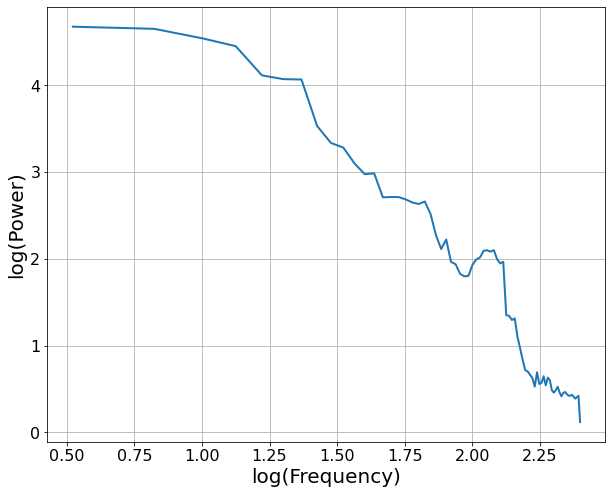

In [30]:
# plot spectra
i_chan = 960
for i_trial in range(0, spectra.shape[0], 10):
    plot_spectrum(freq[1:], spectra[i_trial, i_chan, 1:], log_freqs=True, log_powers=True)

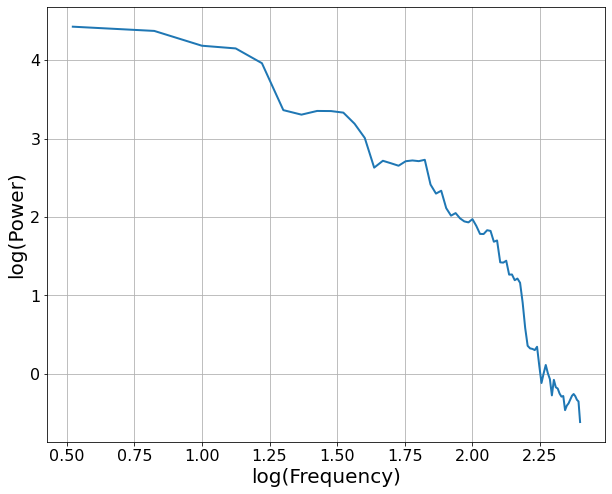

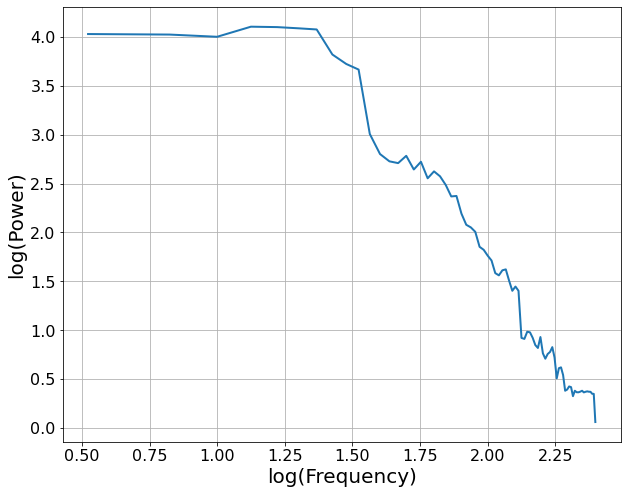

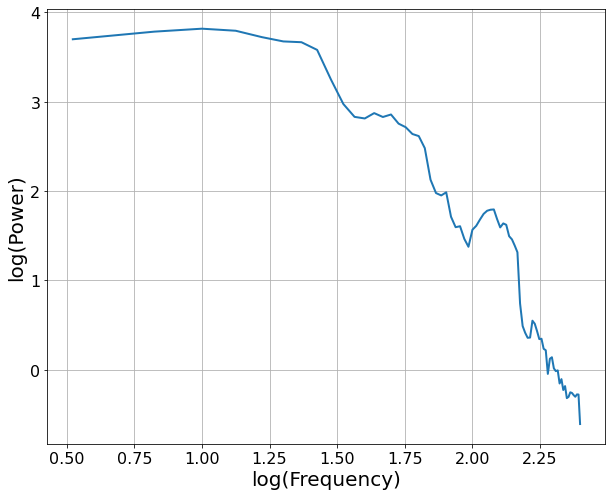

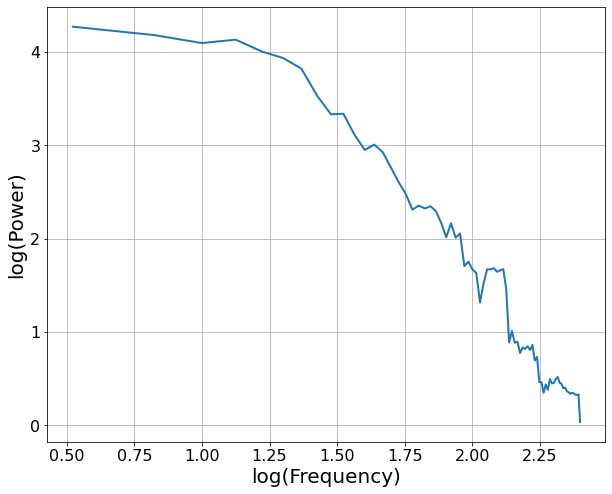

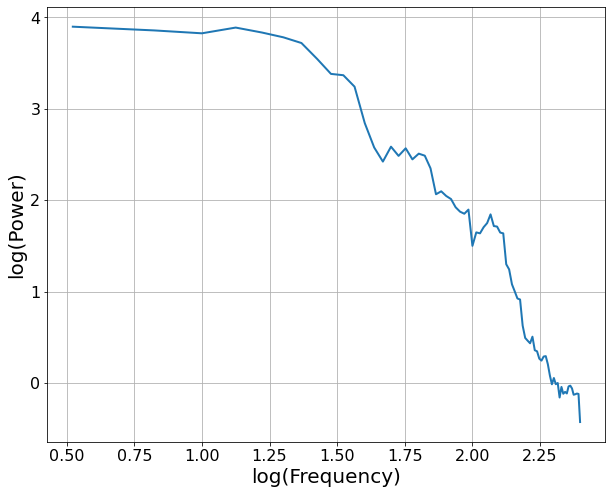

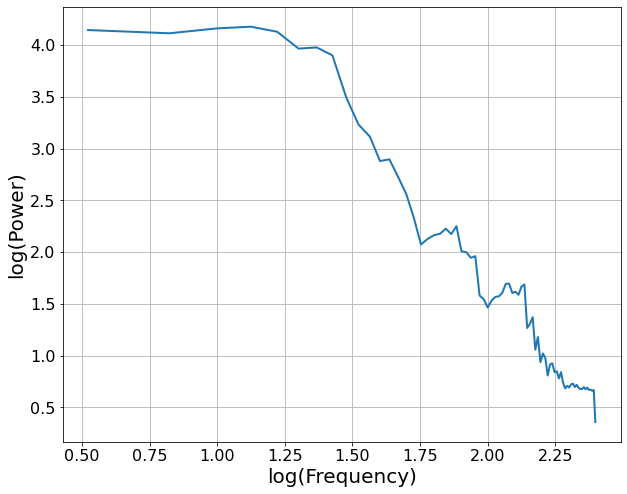

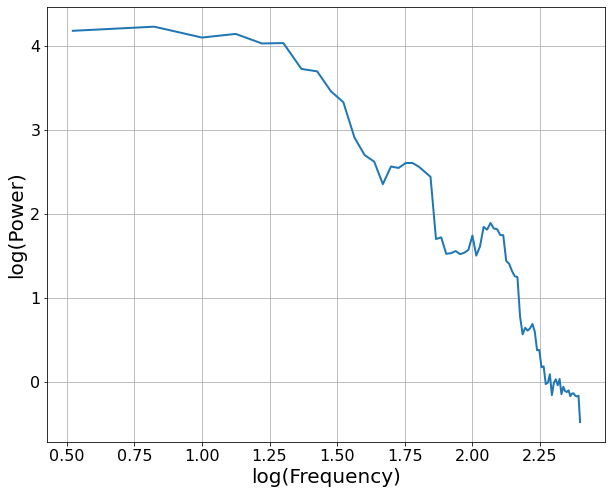

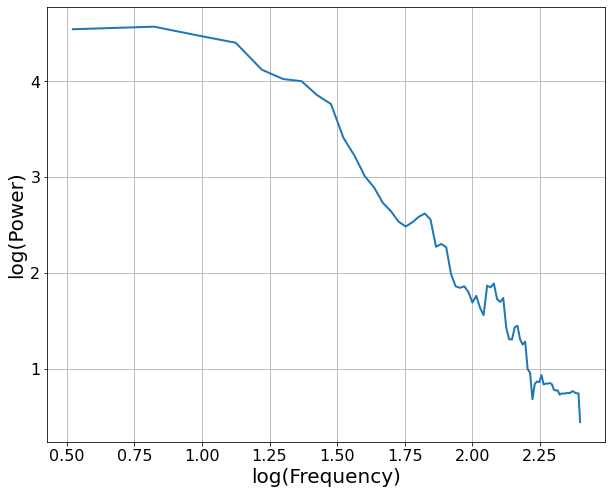

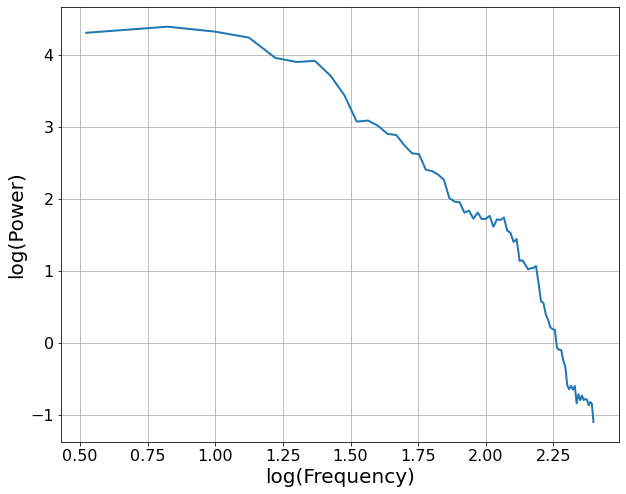

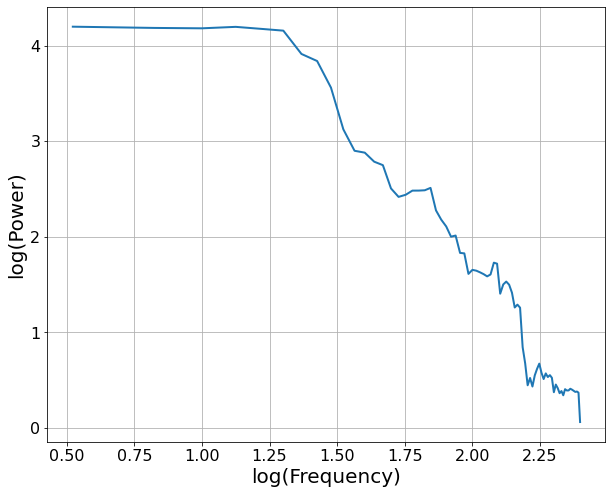

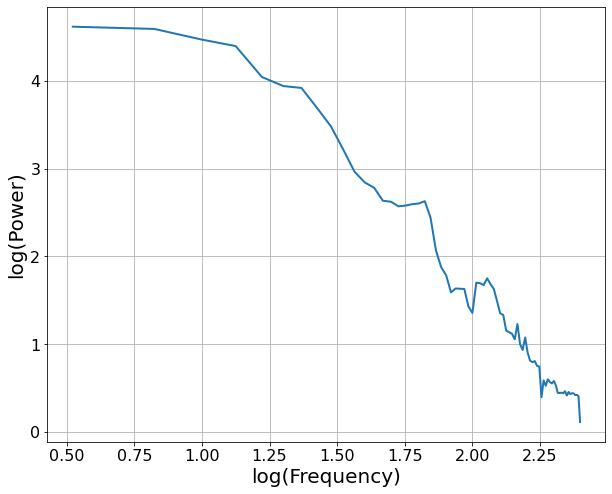

In [31]:
# plot spectra
i_chan = 965
for i_trial in range(0, spectra.shape[0], 10):
    plot_spectrum(freq[1:], spectra[i_trial, i_chan, 1:], log_freqs=True, log_powers=True)

There appears to be a lot of variability between trials. There are trials with a single clear peak (at variable frequencies), 2 clear peaks, and those with broad power above the aperiodic. Furthermore, there are clear spectral peaks above 100 Hz (the upper limit of our fitting range)